In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time


In [2]:
data_dir = './RAFDB'
batch_size = 64
num_classes = 7

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                     
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))     
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
class_names = train_dataset.classes


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load pretrained model
model = EfficientNet.from_pretrained('efficientnet-b0')

# replace fc layer
model._fc = nn.Sequential(
    nn.Linear(model._fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)


model = model.to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


Loaded pretrained weights for efficientnet-b0


In [4]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=7):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_val_acc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validating", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct.double() / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}')

        # EarlyStopping based on val accuracy
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [5]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer)

Epoch 1/100 | Train Loss: 1.3625, Acc: 0.5022 | Val Loss: 1.0178, Acc: 0.6317


Epoch 2/100 | Train Loss: 0.8749, Acc: 0.6921 | Val Loss: 0.7321, Acc: 0.7438


Epoch 3/100 | Train Loss: 0.6700, Acc: 0.7646 | Val Loss: 0.6241, Acc: 0.7862


Epoch 4/100 | Train Loss: 0.5368, Acc: 0.8131 | Val Loss: 0.6235, Acc: 0.7777


Epoch 5/100 | Train Loss: 0.4419, Acc: 0.8409 | Val Loss: 0.5594, Acc: 0.8038


Epoch 6/100 | Train Loss: 0.3638, Acc: 0.8719 | Val Loss: 0.5472, Acc: 0.8090


Epoch 7/100 | Train Loss: 0.3044, Acc: 0.8910 | Val Loss: 0.5739, Acc: 0.8171


Epoch 8/100 | Train Loss: 0.2550, Acc: 0.9089 | Val Loss: 0.6059, Acc: 0.8093


Epoch 9/100 | Train Loss: 0.2122, Acc: 0.9267 | Val Loss: 0.6122, Acc: 0.8149


Epoch 10/100 | Train Loss: 0.1724, Acc: 0.9412 | Val Loss: 0.6499, Acc: 0.8096


Epoch 11/100 | Train Loss: 0.1501, Acc: 0.9486 | Val Loss: 0.6837, Acc: 0.8119


Epoch 12/100 | Train Loss: 0.1317, Acc: 0.9550 | Val Loss: 0.6617, Acc: 0.8093


Epoch 13/100 | Train Loss: 0.1082, Acc: 0.9629 | Val Loss: 0.6979, Acc: 0.8250


Epoch 14/100 | Train Loss: 0.0928, Acc: 0.9681 | Val Loss: 0.7153, Acc: 0.8191


Epoch 15/100 | Train Loss: 0.0896, Acc: 0.9694 | Val Loss: 0.7457, Acc: 0.8178


Epoch 16/100 | Train Loss: 0.0845, Acc: 0.9712 | Val Loss: 0.7644, Acc: 0.8123


Epoch 17/100 | Train Loss: 0.0747, Acc: 0.9743 | Val Loss: 0.7863, Acc: 0.8259


Epoch 18/100 | Train Loss: 0.0646, Acc: 0.9779 | Val Loss: 0.7468, Acc: 0.8237


Epoch 19/100 | Train Loss: 0.0647, Acc: 0.9784 | Val Loss: 0.8038, Acc: 0.8240


Epoch 20/100 | Train Loss: 0.0556, Acc: 0.9821 | Val Loss: 0.8851, Acc: 0.8188


Epoch 21/100 | Train Loss: 0.0540, Acc: 0.9824 | Val Loss: 0.7998, Acc: 0.8207


Epoch 22/100 | Train Loss: 0.0484, Acc: 0.9824 | Val Loss: 0.8862, Acc: 0.8168


Epoch 23/100 | Train Loss: 0.0527, Acc: 0.9824 | Val Loss: 0.8018, Acc: 0.8331


Epoch 24/100 | Train Loss: 0.0506, Acc: 0.9827 | Val Loss: 0.8262, Acc: 0.8211


Epoch 25/100 | Train Loss: 0.0463, Acc: 0.9840 | Val Loss: 0.8324, Acc: 0.8292


Epoch 26/100 | Train Loss: 0.0457, Acc: 0.9852 | Val Loss: 0.8105, Acc: 0.8282


Epoch 27/100 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.8105, Acc: 0.8305


Epoch 28/100 | Train Loss: 0.0383, Acc: 0.9872 | Val Loss: 0.9123, Acc: 0.8282


Epoch 29/100 | Train Loss: 0.0373, Acc: 0.9879 | Val Loss: 0.8328, Acc: 0.8263


Epoch 30/100 | Train Loss: 0.0324, Acc: 0.9897 | Val Loss: 0.8304, Acc: 0.8256
Early stopping


In [6]:
from sklearn.metrics import classification_report
import pandas as pd


model.eval()
all_preds = []
all_labels = []


with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()


print(report_df)



              precision    recall  f1-score      support
1              0.763158  0.793313  0.777943   329.000000
2              0.639344  0.527027  0.577778    74.000000
3              0.557143  0.487500  0.520000   160.000000
4              0.941790  0.914768  0.928082  1185.000000
5              0.846325  0.794979  0.819849   478.000000
6              0.670520  0.716049  0.692537   162.000000
7              0.764628  0.845588  0.803073   680.000000
accuracy       0.825619  0.825619  0.825619     0.825619
macro avg      0.740415  0.725604  0.731323  3068.000000
weighted avg   0.826815  0.825619  0.825243  3068.000000


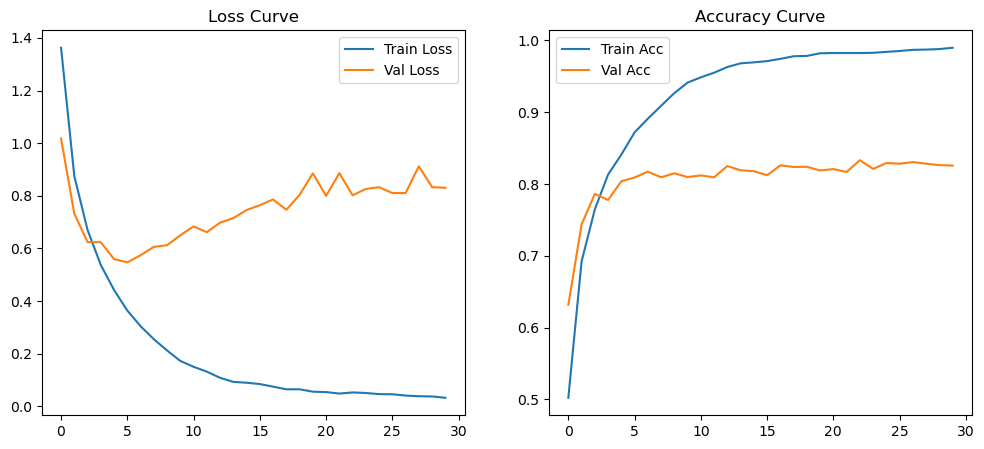

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()


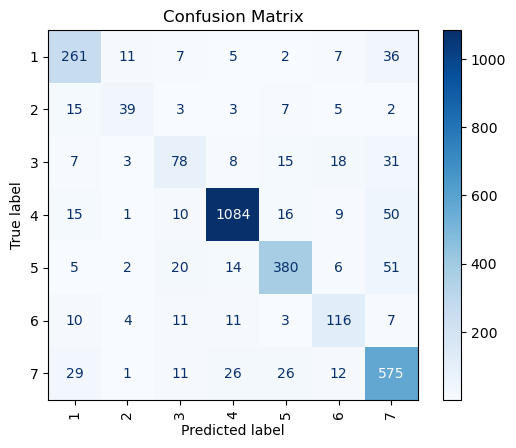

In [8]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')  
plt.title("Confusion Matrix")
plt.show()


Correct Predictions:


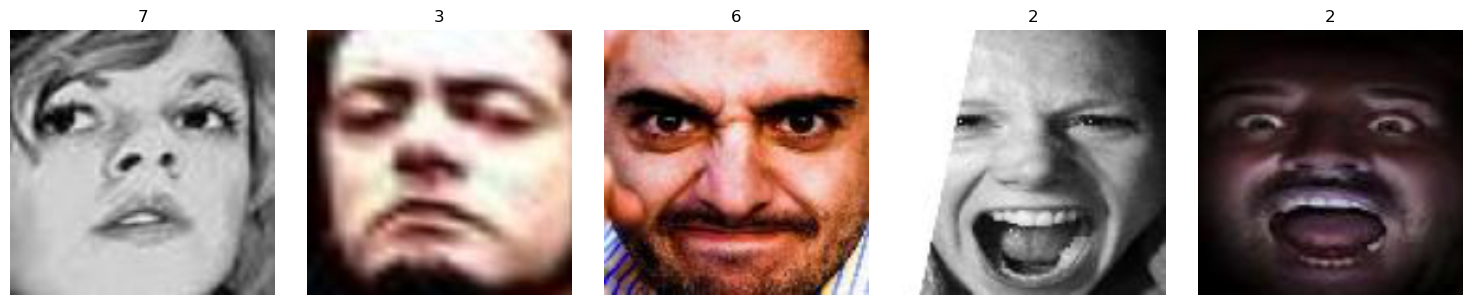

Incorrect Predictions:


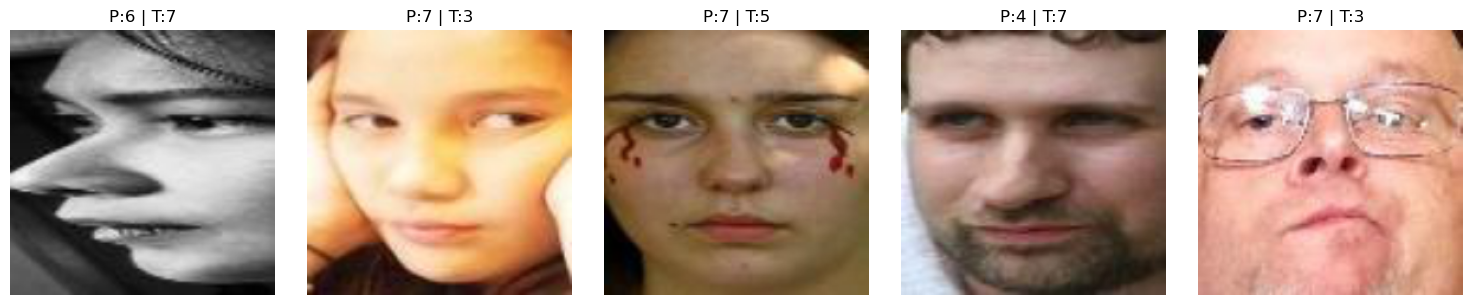

In [9]:
import random

def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

correct, incorrect = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(inputs.size(0)):
            if preds[i].cpu() == labels[i]:
                correct.append((inputs[i].cpu(), preds[i].item()))
            else:
                incorrect.append((inputs[i].cpu(), preds[i].item(), labels[i].item()))

# Show 5 correct
print("Correct Predictions:")
correct_samples = random.sample(correct, 5)
fig, axarr = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axarr[i]
    ax.axis('off')
    img = unnormalize(correct_samples[i][0])
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    ax.set_title(f'{class_names[correct_samples[i][1]]}')
plt.tight_layout()
plt.show()

# Show 5 incorrect
print("Incorrect Predictions:")
incorrect_samples = random.sample(incorrect, 5)
fig, axarr = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axarr[i]
    ax.axis('off')
    img = unnormalize(incorrect_samples[i][0])
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    pred, true = class_names[incorrect_samples[i][1]], class_names[incorrect_samples[i][2]]
    ax.imshow(inp)
    ax.set_title(f'P:{pred} | T:{true}')
plt.tight_layout()
plt.show()
